# Lab3. Données des haute-frequence - Simulation de Processus de Poisson
ZHANG Mian \
CentraleSupélec

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import scipy.stats
from scipy.interpolate import CubicSpline
import os

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Time homogeneous Poisson process

###### 1.1 Compare the computational cost of the two proposed simulation algorithms for the time-homogeneous Poisson process. (You may use the magic %%timeit).

In [3]:
def simulate_intervals(l,T):
    res = []
    t = 0
    while t<T:
        s = scipy.stats.expon.rvs(1/l)
        t = t+s
        res += [t]
    return res[:-1]

def simulate_order_stats(l,T):
    N = scipy.stats.poisson.rvs(l*T)
    u = np.random.random(size = N)*T
    return np.sort(u)

times1 = 0
times2 = 0
n = 1000
l = 10
T = 10
for i in range(n):
    t = time.time()
    t1 = simulate_intervals(l,T)
    times1 += (time.time()-t)/n
    t = time.time()
    t2 = simulate_order_stats(l,T)
    times2 += (time.time()-t)/n

print("simulation time with interarrival times (average over 1000 runs, in seconds):",times1)
print("simulation time with oder statistics method:",times2)

simulation time with interarrival times (average over 1000 runs, in seconds): 0.00038200926780700736
simulation time with oder statistics method: 7.00311660766602e-05


The order statistics method seems faster.

## 2. A non homogeneous Poisson process for trades

2.1 Propose a fit for the intensity of one day of trades for one stock (use Lab 1 data), e.g., using cubic splines with points every 10 minutes. It may be useful to work with timestamps in [0,T] using seconds as units, and use scipy.interpolate.CubicSpline(...). \
2.2 Simulate a Poisson process with this fitted intensity. Compare the empirical and simulated distributions of durations with, e.g., histograms, cumulative distribution function, quantile plots. Comment on the goodness-of-fit of a non-homogeneous Poisson process for trades.


In [4]:
def get_intensities(dfs,t):#extract the median number of trades per second (sampled every t minutes)
    volumes = []
    for df in dfs:
        mvols = df.resample(str(t)+"T",on = "ts").sum()["one"].to_numpy()/(t*60)
        volumes += [mvols]
    median_vols = np.median(volumes,axis = 0)
    times = np.arange(0,len(median_vols),1)*t*60
    return times,median_vols

def fit(intensity,times,tol = 0):#fits a cubic spline to the empirical intensity
    cs = CubicSpline(times,intensity)
    return cs,np.max(intensity) + tol

def simulate_non_homogeneous(l,lstar,T):#simulates a non homegeneous Poisson process with thinning
    tstar = simulate_order_stats(lstar,T)
    rs = l(tstar)/lstar
    draws = np.random.random(size = len(tstar))
    res = tstar[draws < rs]
    return res

In [6]:
path = "/content/drive/MyDrive/TOTF.PA/"
l = os.listdir(path)
dfs = []
for name in l:
    if "trades" in name:
        dfs += [pd.read_csv(path+name)]
        dfs[-1]["ts"] = pd.to_datetime(dfs[-1]["ts"])
        dfs[-1]["time_in_s"] = pd.to_datetime(dfs[-1]["ts"]).dt.hour*3600 + pd.to_datetime(dfs[-1]["ts"]).dt.minute*60 + pd.to_datetime(dfs[-1]["ts"]).dt.second + pd.to_datetime(dfs[-1]["ts"]).dt.microsecond/1000000
        dfs[-1]["one"] = 1

In [7]:
times,intensity = get_intensities(dfs,10)
T = times[-1]
l,lstar = fit(intensity,times,tol = 0.5)

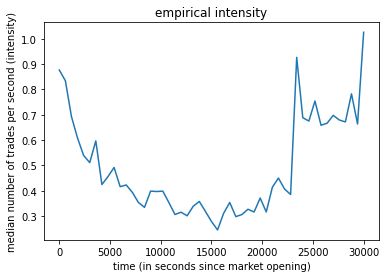

In [8]:
fig,ax = plt.subplots()
ax.plot(times,intensity)
ax.set_title("empirical intensity")
ax.set_xlabel("time (in seconds since market opening)")
ax.set_ylabel("median number of trades per second (intensity)");

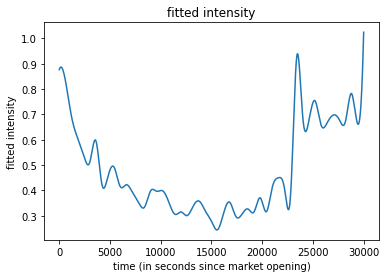

In [9]:
fig,ax = plt.subplots()
ax.plot(l(np.arange(0,T,1)))
ax.set_title("fitted intensity")
ax.set_xlabel("time (in seconds since market opening)")
ax.set_ylabel("fitted intensity");

In [10]:
sim = simulate_non_homogeneous(l,lstar,T)

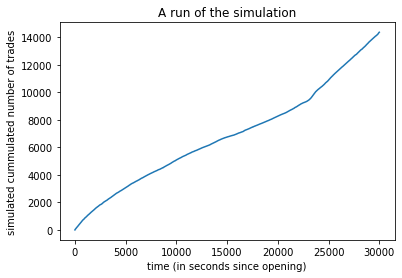

In [11]:
fig,ax = plt.subplots()
ax.plot(sim,np.arange(0,len(sim),1))
ax.set_xlabel("time (in seconds since opening)")
ax.set_ylabel("simulated cummulated number of trades")
ax.set_title("A run of the simulation");

The above plot allows us to check that the simulation ran correctly, as it shows an higher trading intensity in the morning and in the evening (steeper slopes in the cumulated number of trades) aligned with the higher regions in the measured intensity.

In [12]:
diff_sim = np.diff(sim)

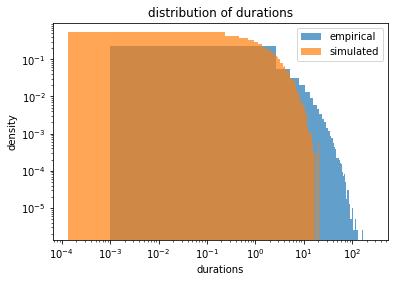

In [13]:
diffs = []
for df in dfs:
    diff = np.diff(df["time_in_s"].to_numpy())
    diffs += [diff]
diffs = np.concatenate(diffs)
diffs = diffs[diffs>0]
fig,ax = plt.subplots()
ax.hist(diffs,bins = 100,density = True,alpha=0.7)
ax.hist(diff_sim,bins = 100,density = True,alpha=0.7)
ax.set_xlabel("durations")
ax.set_ylabel("density")
ax.set_title("distribution of durations")
ax.legend(["empirical","simulated"])
plt.yscale("log")
plt.xscale("log")

The simulated distribution has a less heavy tail than the empirical one. The non-homogeneous Poisson process is not a good fit for trades' durations.